In [1]:
# general:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV       # hyperparam selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef  # matric for performance evaluation in training
# self-writtten:
import data_cleaner as dc  # self-writtten data cleaning functions
import ML_func as ml       # self-written ML related functions
pd.set_option('display.max_rows', 500)  # let pd.df display() 500 rows
pd.set_option('display.max_columns', 500)

In [50]:
x_train = pd.read_csv("../clean_data/mci_wv1go_imp.csv")   # use imputed data
x_test = pd.read_csv("../clean_data/mci_wv23_imp.csv")   
y_train = x_train.pop("progress")
y_test = x_test.pop("progress")
x_train, train_imp_mean_sd = dc.standardization(x_train)
x_test, test_imp_mean_sd = dc.standardization(x_test)

In [55]:
# categorical_features as int & unique class < 10:
cat_cols = x_train.apply(lambda x : (x.dtype=="int64") and (len(x.unique())<10) )
cat_cols = x_train.columns[cat_cols].to_list()
for c in cat_cols:
    x_train[c] = x_train[c].astype('category')
    x_test[c] = x_test[c].astype('category')


# print(x_train[cat_cols].apply(lambda x: x.unique()) )
# from sklearn.preprocessing import LabelEncoder  # label encoding
# le = LabelEncoder()
# x_train.PTRACCAT = le.fit_transform(x_train.PTRACCAT)
# x_train.MMSE = le.fit_transform(x_train.MMSE)
# print(x_train[cat_cols].apply(lambda x: x.unique()) )

In [110]:
import lightgbm as lgb
# lgb.LGBMClassifier().get_params()   # check default
params = {
    'num_leaves':[10,20,31],           # key to ctrl overfit
    'learning_rate':[0.02, 0.05, 0.1, 0.3],       # learning rate
    # 'max_depth':            # leaves more important because leaf-wise growth
    # 'n_estimators':[50,100,300],
    #'reg_alpha':[0,1,2],   # L1 regularization
    'reg_lambda':[0,1,2]   # L2 regularization
    
}
mod_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', seed=1)  
cv_lgb = GridSearchCV(
    estimator = mod_lgb, 
    param_grid=params,
    cv=10, verbose=0,
    scoring = 'matthews_corrcoef'  # because outcome imbalanced
)
cv_lgb.fit(x_train, y_train)       
pd.DataFrame(cv_lgb.cv_results_).sort_values("rank_test_score").head() 

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_num_leaves,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
19,0.253926,0.018139,0.003449,0.000534,0.1,10,1,"{'learning_rate': 0.1, 'num_leaves': 10, 'reg_...",0.298199,0.472713,0.234868,0.124642,0.555234,0.609438,0.465818,0.639804,0.371455,0.360772,0.413294,0.157838,1
21,0.472890,0.074054,0.003833,0.000715,0.1,20,0,"{'learning_rate': 0.1, 'num_leaves': 20, 'reg_...",0.216338,0.412306,0.208423,-0.005193,0.484165,0.406566,0.540878,0.639804,0.525443,0.441637,0.387037,0.183040,2
16,0.432723,0.034837,0.004154,0.000681,0.05,31,1,"{'learning_rate': 0.05, 'num_leaves': 31, 'reg...",0.254478,0.376633,0.232627,0.086280,0.484165,0.358891,0.540878,0.513353,0.513353,0.445271,0.380593,0.141689,3
15,0.675697,0.097523,0.003862,0.000370,0.05,31,0,"{'learning_rate': 0.05, 'num_leaves': 31, 'reg...",0.301244,0.481264,0.264478,0.048073,0.406566,0.358891,0.406566,0.639804,0.525443,0.361029,0.379336,0.151935,4
25,0.413762,0.038074,0.003895,0.000580,0.1,31,1,"{'learning_rate': 0.1, 'num_leaves': 31, 'reg_...",0.266029,0.348635,0.208423,0.018828,0.437167,0.406566,0.540878,0.583114,0.513353,0.445271,0.376827,0.163374,5


In [119]:
pd.DataFrame(cv_lgb.cv_results_).sort_values("rank_test_score")
# ml.vote_hyperparam(cv_lgb.cv_results_, top_n=7)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_num_leaves,param_reg_lambda,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
19,0.253926,0.018139,0.003449,0.000534,0.1,10,1,"{'learning_rate': 0.1, 'num_leaves': 10, 'reg_...",0.298199,0.472713,0.234868,0.124642,0.555234,0.609438,0.465818,0.639804,0.371455,0.360772,0.413294,0.157838,1
21,0.472890,0.074054,0.003833,0.000715,0.1,20,0,"{'learning_rate': 0.1, 'num_leaves': 20, 'reg_...",0.216338,0.412306,0.208423,-0.005193,0.484165,0.406566,0.540878,0.639804,0.525443,0.441637,0.387037,0.183040,2
16,0.432723,0.034837,0.004154,0.000681,0.05,31,1,"{'learning_rate': 0.05, 'num_leaves': 31, 'reg...",0.254478,0.376633,0.232627,0.086280,0.484165,0.358891,0.540878,0.513353,0.513353,0.445271,0.380593,0.141689,3
15,0.675697,0.097523,0.003862,0.000370,0.05,31,0,"{'learning_rate': 0.05, 'num_leaves': 31, 'reg...",0.301244,0.481264,0.264478,0.048073,0.406566,0.358891,0.406566,0.639804,0.525443,0.361029,0.379336,0.151935,4
25,0.413762,0.038074,0.003895,0.000580,0.1,31,1,"{'learning_rate': 0.1, 'num_leaves': 31, 'reg_...",0.266029,0.348635,0.208423,0.018828,0.437167,0.406566,0.540878,0.583114,0.513353,0.445271,0.376827,0.163374,5
13,0.399747,0.028323,0.003564,0.000458,0.05,20,1,"{'learning_rate': 0.05, 'num_leaves': 20, 'reg...",0.160036,0.376633,0.280554,0.048073,0.484165,0.406566,0.540878,0.639804,0.457490,0.361029,0.375523,0.167201,6
24,0.677675,0.082241,0.004189,0.000754,0.1,31,0,"{'learning_rate': 0.1, 'num_leaves': 31, 'reg_...",0.254478,0.442105,0.208423,0.095254,0.319756,0.358891,0.465818,0.639804,0.525443,0.360772,0.367074,0.151302,7
35,0.395393,0.025380,0.003733,0.000508,0.3,31,2,"{'learning_rate': 0.3, 'num_leaves': 31, 'reg_...",0.160036,0.407553,0.131250,0.018828,0.484165,0.437167,0.465818,0.513353,0.480102,0.517815,0.361609,0.175032,8
31,0.396820,0.035453,0.003591,0.000453,0.3,20,1,"{'learning_rate': 0.3, 'num_leaves': 20, 'reg_...",0.301244,0.376633,0.156086,-0.025831,0.437167,0.319100,0.540878,0.578831,0.457490,0.441637,0.358323,0.172785,9
27,0.259001,0.021531,0.003845,0.000515,0.3,10,0,"{'learning_rate': 0.3, 'num_leaves': 10, 'reg_...",0.298199,0.307988,0.184474,0.086280,0.437167,0.233618,0.540878,0.639804,0.411082,0.441637,0.358113,0.159509,10


In [116]:
max_iterator = 500   # num of max trees
lgb_params = ml.vote_hyperparam(cv_lgb.cv_results_, top_n=7)  # top 7 mods similar performance
best_it = []
# lgb_params["num_leaves"] = 20 # to address overfitting
for i in range(5):
    lgb_train, lgb_validate, o_train, o_validate = train_test_split(
        x_train, y_train, train_size=0.8, stratify=y_train, random_state = i*10)
    mod_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', 
                                eval_metric = 'logloss',
                                random_state=i, early_stopping_rounds = max_iterator//10,
                                n_estimators= max_iterator, 
                                **lgb_params  # use ** to unpack dict
                               ) 
    mod_lgb.fit(lgb_train, o_train,
                eval_set=[(lgb_train, o_train), (lgb_validate, o_validate)]) 
    best_it.append(mod_lgb.best_iteration_)
print(f"Best iteration for each round: {best_it}; mean={sum(best_it)/5}")
lgb_it = round(sum(best_it)/5)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[1]	training's binary_logloss: 0.427442	valid_1's binary_logloss: 0.434558
[2]	training's binary_logloss: 0.401624	valid_1's binary_logloss: 0.41776
[3]	training's binary_logloss: 0.379618	valid_1's binary_logloss: 0.407135
[4]	training's binary_logloss: 0.360896	valid_1's binary_logloss: 0.397806
[5]	training's binary_logloss: 0.342703	valid_1's binary_logloss: 0.389745
[6]	training's binary_logloss: 0.3279	valid_1's binary_logloss: 0.385104
[7]	training's binary_logloss: 0.313083	valid_1's binary_logloss: 0.380147
[8]	training's binary_logloss: 0.299837	valid_1's binary_logloss: 0.37565
[9]	training's binary_logloss: 0.288648	valid_1's binary_logloss: 0.371072
[10]	training's binary_logloss: 0.276477	valid_1's binary_logloss: 0.366956
[11]	training's binary_logloss: 0.265553	valid_1's binary_logloss: 

/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[52]	training's binary_logloss: 0.0678469	valid_1's binary_logloss: 0.375893
[53]	training's binary_logloss: 0.0658528	valid_1's binary_logloss: 0.376113
[54]	training's binary_logloss: 0.0642285	valid_1's binary_logloss: 0.378566
[55]	training's binary_logloss: 0.0625609	valid_1's binary_logloss: 0.379444
[56]	training's binary_logloss: 0.0605571	valid_1's binary_logloss: 0.381363
[57]	training's binary_logloss: 0.0591382	valid_1's binary_logloss: 0.38345
[58]	training's binary_logloss: 0.0574436	valid_1's binary_logloss: 0.385452
[59]	training's binary_logloss: 0.0561149	valid_1's binary_logloss: 0.388395
[60]	training's binary_logloss: 0.0548123	valid_1's binary_logloss: 0.388694
[61]	training's binary_logloss: 0.0533352	valid_1's binary_logloss: 0.389823
[62]	training's binary_logloss: 0.0519754	valid_1's binary_logloss: 0.390174
[63]	training's binary_logloss: 0.0505017	valid_1's binary_logloss: 0.392583
[64]	training's binary_logloss: 0.0489661	valid_1's binary_logloss: 0.396064


/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[22]	training's binary_logloss: 0.180255	valid_1's binary_logloss: 0.334911
[23]	training's binary_logloss: 0.175185	valid_1's binary_logloss: 0.334273
[24]	training's binary_logloss: 0.169007	valid_1's binary_logloss: 0.336612
[25]	training's binary_logloss: 0.163775	valid_1's binary_logloss: 0.33665
[26]	training's binary_logloss: 0.157646	valid_1's binary_logloss: 0.336931
[27]	training's binary_logloss: 0.153444	valid_1's binary_logloss: 0.334458
[28]	training's binary_logloss: 0.148127	valid_1's binary_logloss: 0.335511
[29]	training's binary_logloss: 0.142919	valid_1's binary_logloss: 0.335979
[30]	training's binary_logloss: 0.13775	valid_1's binary_logloss: 0.334311
[31]	training's binary_logloss: 0.133031	valid_1's binary_logloss: 0.333077
[32]	training's binary_logloss: 0.128207	valid_1's binary_logloss: 0.335102
[33]	training's binary_logloss: 0.12392	valid_1's binary_logloss: 0.333048
[34]	training's binary_logloss: 0.120114	valid_1's binary_logloss: 0.334662
[35]	training's

/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[34]	training's binary_logloss: 0.11677	valid_1's binary_logloss: 0.323868
[35]	training's binary_logloss: 0.112699	valid_1's binary_logloss: 0.320684
[36]	training's binary_logloss: 0.108639	valid_1's binary_logloss: 0.322585
[37]	training's binary_logloss: 0.105643	valid_1's binary_logloss: 0.324125
[38]	training's binary_logloss: 0.102629	valid_1's binary_logloss: 0.324892
[39]	training's binary_logloss: 0.0996575	valid_1's binary_logloss: 0.326262
[40]	training's binary_logloss: 0.0959901	valid_1's binary_logloss: 0.32472
[41]	training's binary_logloss: 0.0928156	valid_1's binary_logloss: 0.322005
[42]	training's binary_logloss: 0.089765	valid_1's binary_logloss: 0.322139
[43]	training's binary_logloss: 0.0872162	valid_1's binary_logloss: 0.321283
[44]	training's binary_logloss: 0.0846743	valid_1's binary_logloss: 0.321737
[45]	training's binary_logloss: 0.081819	valid_1's binary_logloss: 0.321651
[46]	training's binary_logloss: 0.0794074	valid_1's binary_logloss: 0.321132
[47]	tra

/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[23]	training's binary_logloss: 0.165279	valid_1's binary_logloss: 0.356668
[24]	training's binary_logloss: 0.159768	valid_1's binary_logloss: 0.35677
[25]	training's binary_logloss: 0.154329	valid_1's binary_logloss: 0.35519
[26]	training's binary_logloss: 0.149329	valid_1's binary_logloss: 0.353475
[27]	training's binary_logloss: 0.144201	valid_1's binary_logloss: 0.355178
[28]	training's binary_logloss: 0.14028	valid_1's binary_logloss: 0.354456
[29]	training's binary_logloss: 0.13508	valid_1's binary_logloss: 0.356339
[30]	training's binary_logloss: 0.130166	valid_1's binary_logloss: 0.35732
[31]	training's binary_logloss: 0.125826	valid_1's binary_logloss: 0.360647
[32]	training's binary_logloss: 0.122028	valid_1's binary_logloss: 0.361094
[33]	training's binary_logloss: 0.117958	valid_1's binary_logloss: 0.360711
[34]	training's binary_logloss: 0.114039	valid_1's binary_logloss: 0.360995
[35]	training's binary_logloss: 0.110651	valid_1's binary_logloss: 0.36287
[36]	training's bi

/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[29]	training's binary_logloss: 0.136293	valid_1's binary_logloss: 0.351764
[30]	training's binary_logloss: 0.13103	valid_1's binary_logloss: 0.352691
[31]	training's binary_logloss: 0.127303	valid_1's binary_logloss: 0.350706
[32]	training's binary_logloss: 0.123225	valid_1's binary_logloss: 0.351529
[33]	training's binary_logloss: 0.118673	valid_1's binary_logloss: 0.353358
[34]	training's binary_logloss: 0.11465	valid_1's binary_logloss: 0.351615
[35]	training's binary_logloss: 0.111265	valid_1's binary_logloss: 0.352435
[36]	training's binary_logloss: 0.107615	valid_1's binary_logloss: 0.355422
[37]	training's binary_logloss: 0.104333	valid_1's binary_logloss: 0.352548
[38]	training's binary_logloss: 0.101242	valid_1's binary_logloss: 0.350577
[39]	training's binary_logloss: 0.0974788	valid_1's binary_logloss: 0.351214
[40]	training's binary_logloss: 0.0944755	valid_1's binary_logloss: 0.351382
[41]	training's binary_logloss: 0.0915651	valid_1's binary_logloss: 0.35283
[42]	trainin

/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/envs/boost/lib/python3.8/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


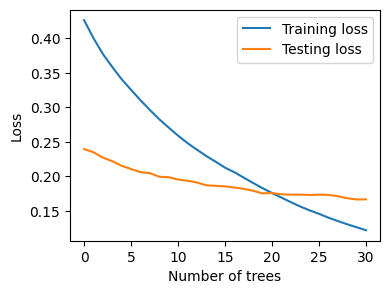

In [117]:
# final model

mod_lgb = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary', 
                                eval_metric = 'logloss',
                                random_state=77,
                                n_estimators= lgb_it, 
                                **lgb_params  # use ** to unpack dict
                               ) 
mod_lgb.fit(x_train, y_train, verbose=0,
            eval_set=[(x_train, y_train), (x_test, y_test)])
results = mod_lgb.evals_result_
plt.figure(figsize=(4,3))
plt.plot(results["training"]["binary_logloss"], label="Training loss")
plt.plot(results["valid_1"]["binary_logloss"], label="Testing loss")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [91]:
result_lgb = {'train_pred':mod_lgb.predict(x_train), 'train_prob':mod_lgb.predict_proba(x_train)[:,1],
  'test_pred':mod_lgb.predict(x_test), 'test_prob':mod_lgb.predict_proba(x_test)[:,1]}
dc.save_py(result_lgb, "output/result_lgb_imp")

In [118]:
y_pred = mod_lgb.predict_proba(x_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 4)
auc

0.8863